In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [2]:
housing = pd.read_csv('housing.csv')
housing.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Only date column is **Object** type. Let's make the date column datatype to int64

In [4]:
housing['date'] = pd.to_datetime(housing.date).view('int64')
housing.date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 21613 entries, 0 to 21612
Series name: date
Non-Null Count  Dtype
--------------  -----
21613 non-null  int64
dtypes: int64(1)
memory usage: 169.0 KB


In [5]:
# checking null values
housing.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Feature Engineering

<AxesSubplot:xlabel='date', ylabel='Count'>

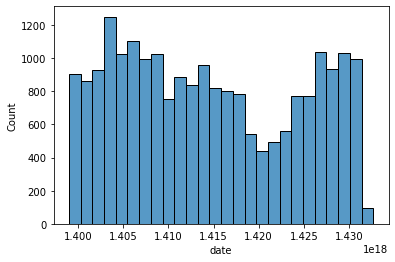

In [6]:
# let's check distribution of  date column
sns.histplot(x='date',data=housing)

In [7]:
# Making a model taking all features under consideration
housing_feature = housing.drop(['price'],axis=1)
X_add_const = sm.add_constant(housing_feature)
lr = sm.OLS(housing['price'],X_add_const).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     62.13
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           5.49e-40
Time:                        00:17:34   Log-Likelihood:            -3.0751e+05
No. Observations:               21613   AIC:                         6.150e+05
Df Residuals:                   21609   BIC:                         6.151e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.752e-10   3.48e-10      0.504

$R^2$ is horrible. **t-stat** of the **`date`** column is highest among all. Let's remove that feature and check again.

In [8]:
housing_feature = housing.drop(['price','date'],axis=1)
X_add_const = sm.add_constant(housing_feature)
lr = sm.OLS(housing['price'],X_add_const).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2797.
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:17:34   Log-Likelihood:            -2.9460e+05
No. Observations:               21613   AIC:                         5.892e+05
Df Residuals:                   21594   BIC:                         5.894e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.939e+06   2.93e+06      2.366

After droping **date** column result is far better$(R^2=70\%)$. Let's remove the date column.

In [9]:
# cereating list of columns to be dropped in future for prediction
DropList = ['price','date']

<AxesSubplot:xlabel='price', ylabel='Count'>

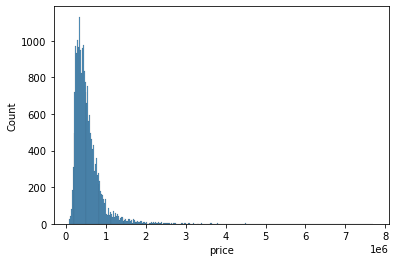

In [10]:
# Checking distribution of target column
sns.histplot(x='price',data=housing)

Distribution of Target column is heavily skewed. Let's remove some outliers from right side.

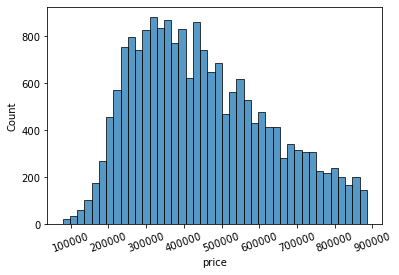

In [11]:
sns.histplot(x='price',data=housing[(housing.price>housing.price.quantile(0.0)) & (housing.price<housing.price.quantile(0.90))])
plt.xticks(rotation=20)
plt.show()

Now target data is almost normally distributed. Let's check model accuracy again.

In [12]:
housing_mod = housing[(housing.price>housing.price.quantile(0.0)) & (housing.price<housing.price.quantile(0.90))]
X_add_const = sm.add_constant(housing_mod.drop(['price','date'],axis=1))
lr = sm.OLS(housing_mod['price'],X_add_const).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     2208.
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:17:38   Log-Likelihood:            -2.5186e+05
No. Observations:               19449   AIC:                         5.038e+05
Df Residuals:                   19430   BIC:                         5.039e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.329e+06   1.57e+06     -5.321

Result is getting worsed after removing outlier from target column.

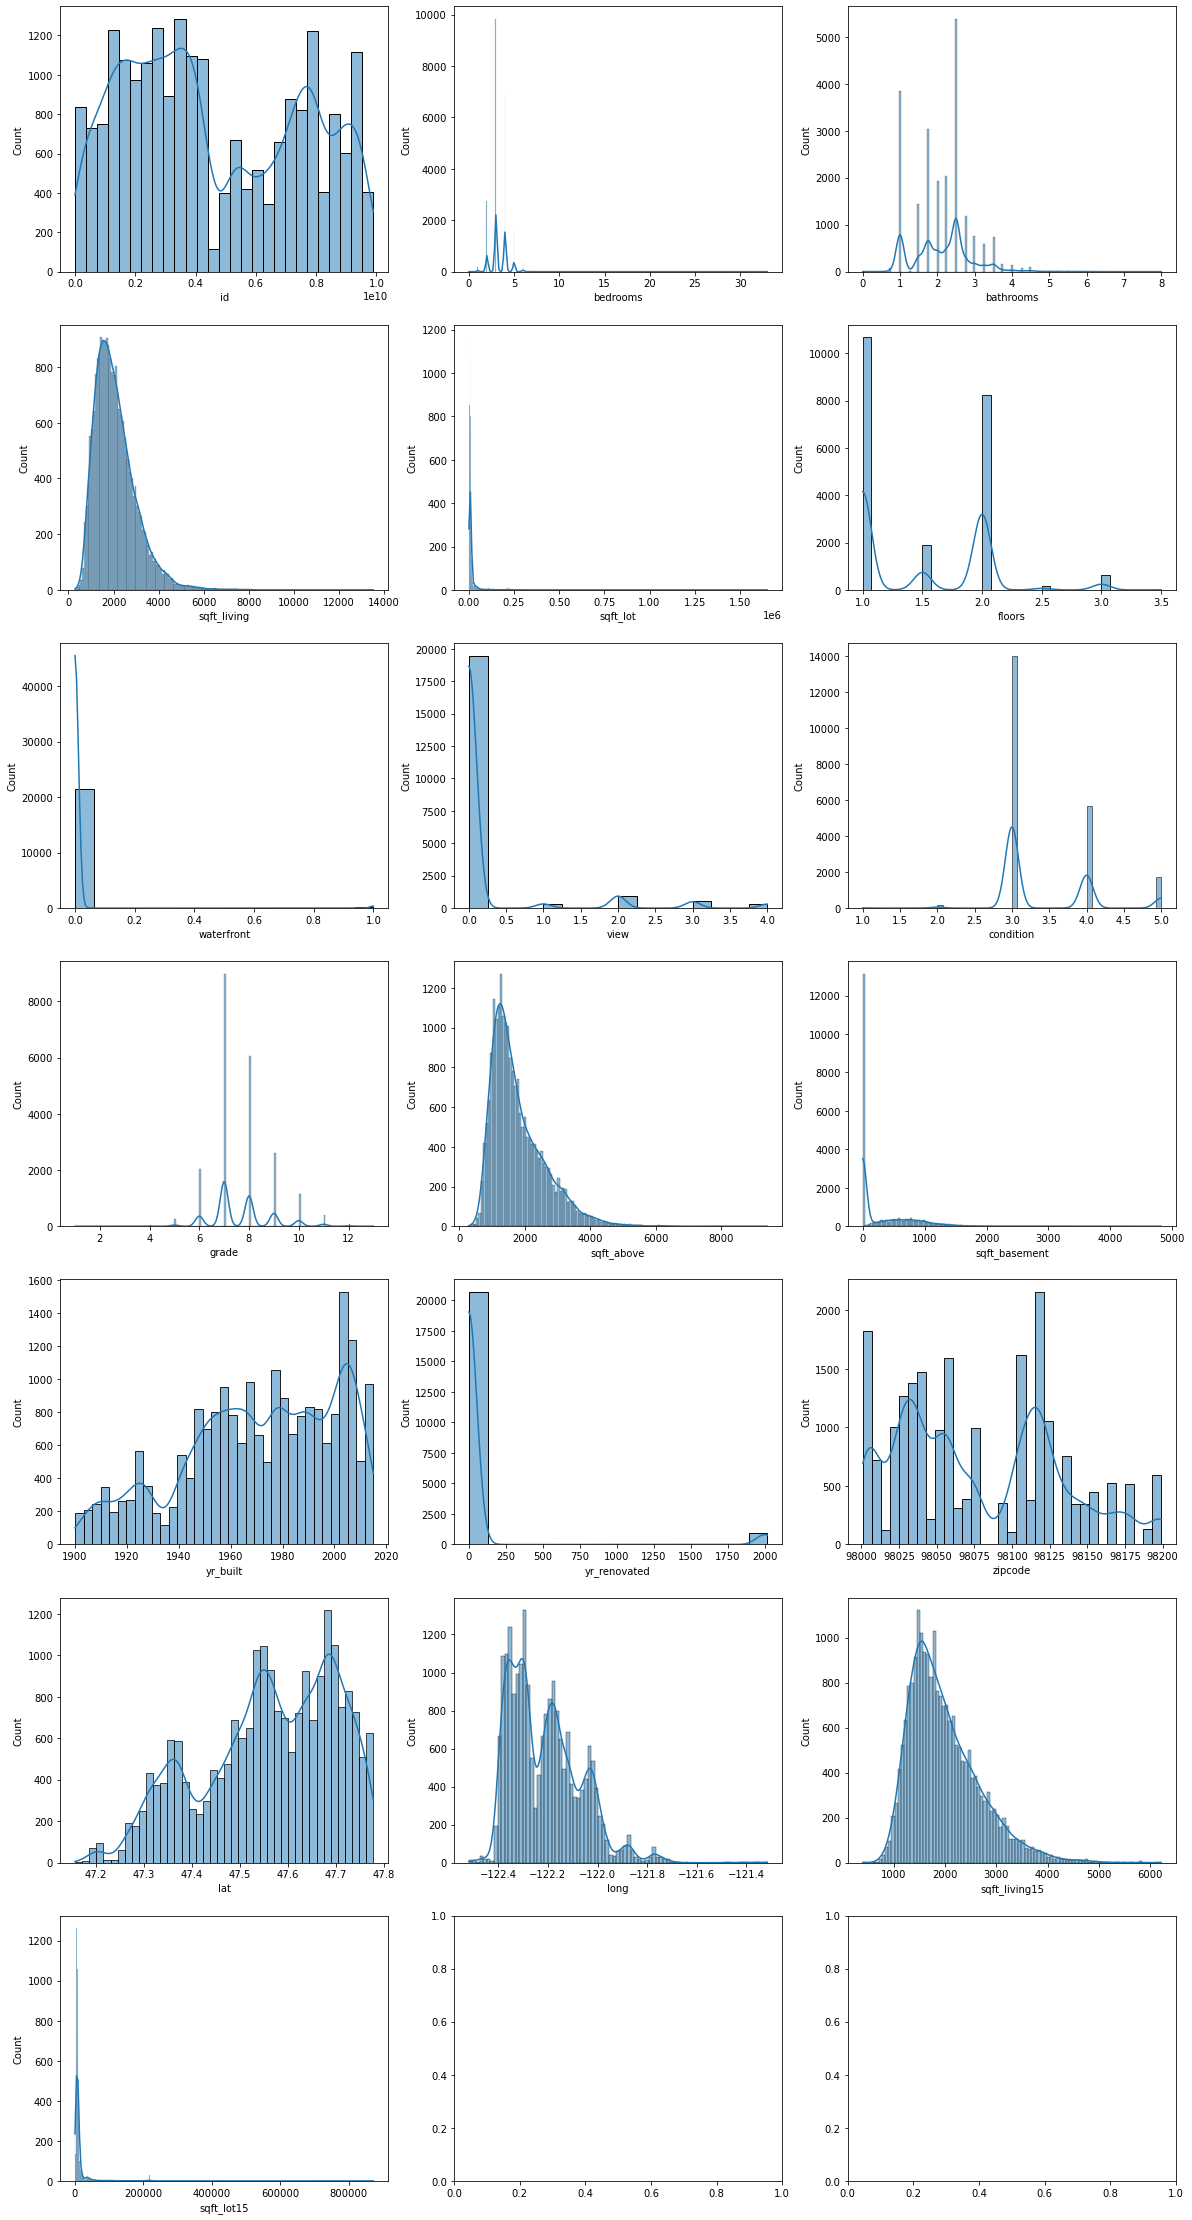

In [13]:
#Histogram plot for each features

#creating feature list 
feature_col = list(housing.drop(DropList,axis=1).columns)

# We have 19 features to plot at 7x3 subplots. 
ncols= 3
nrows= (len(feature_col) + ncols)//ncols


#creating total number of plot for histogram
fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,40))

for index, col_name in enumerate (feature_col):
    plt.subplot(nrows,ncols,index+1)
    sns.histplot(housing[col_name],kde=True)

Let's create the list of features having outlier.

In [14]:
outlier_col = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

housing_no_outlier = housing.copy()
for col_name in outlier_col:
    Q1 = housing[col_name].quantile(0.25)
    Q3 = housing[col_name].quantile(0.75)
    IQR = Q3 - Q1
    UL = Q3 + 1.5 * IQR
    LL = Q1 - 1.5 * IQR
    housing_no_outlier = housing_no_outlier.loc[(housing_no_outlier[col_name]<=UL) & (housing_no_outlier[col_name]>=LL)]

# calculating % data loss after removing outlier
data_loss = (1 - housing_no_outlier.shape[0]/housing.shape[0])*100
print('data_loss after removing outlier = ',np.round(data_loss,2),'%')

data_loss after removing outlier =  18.67 %


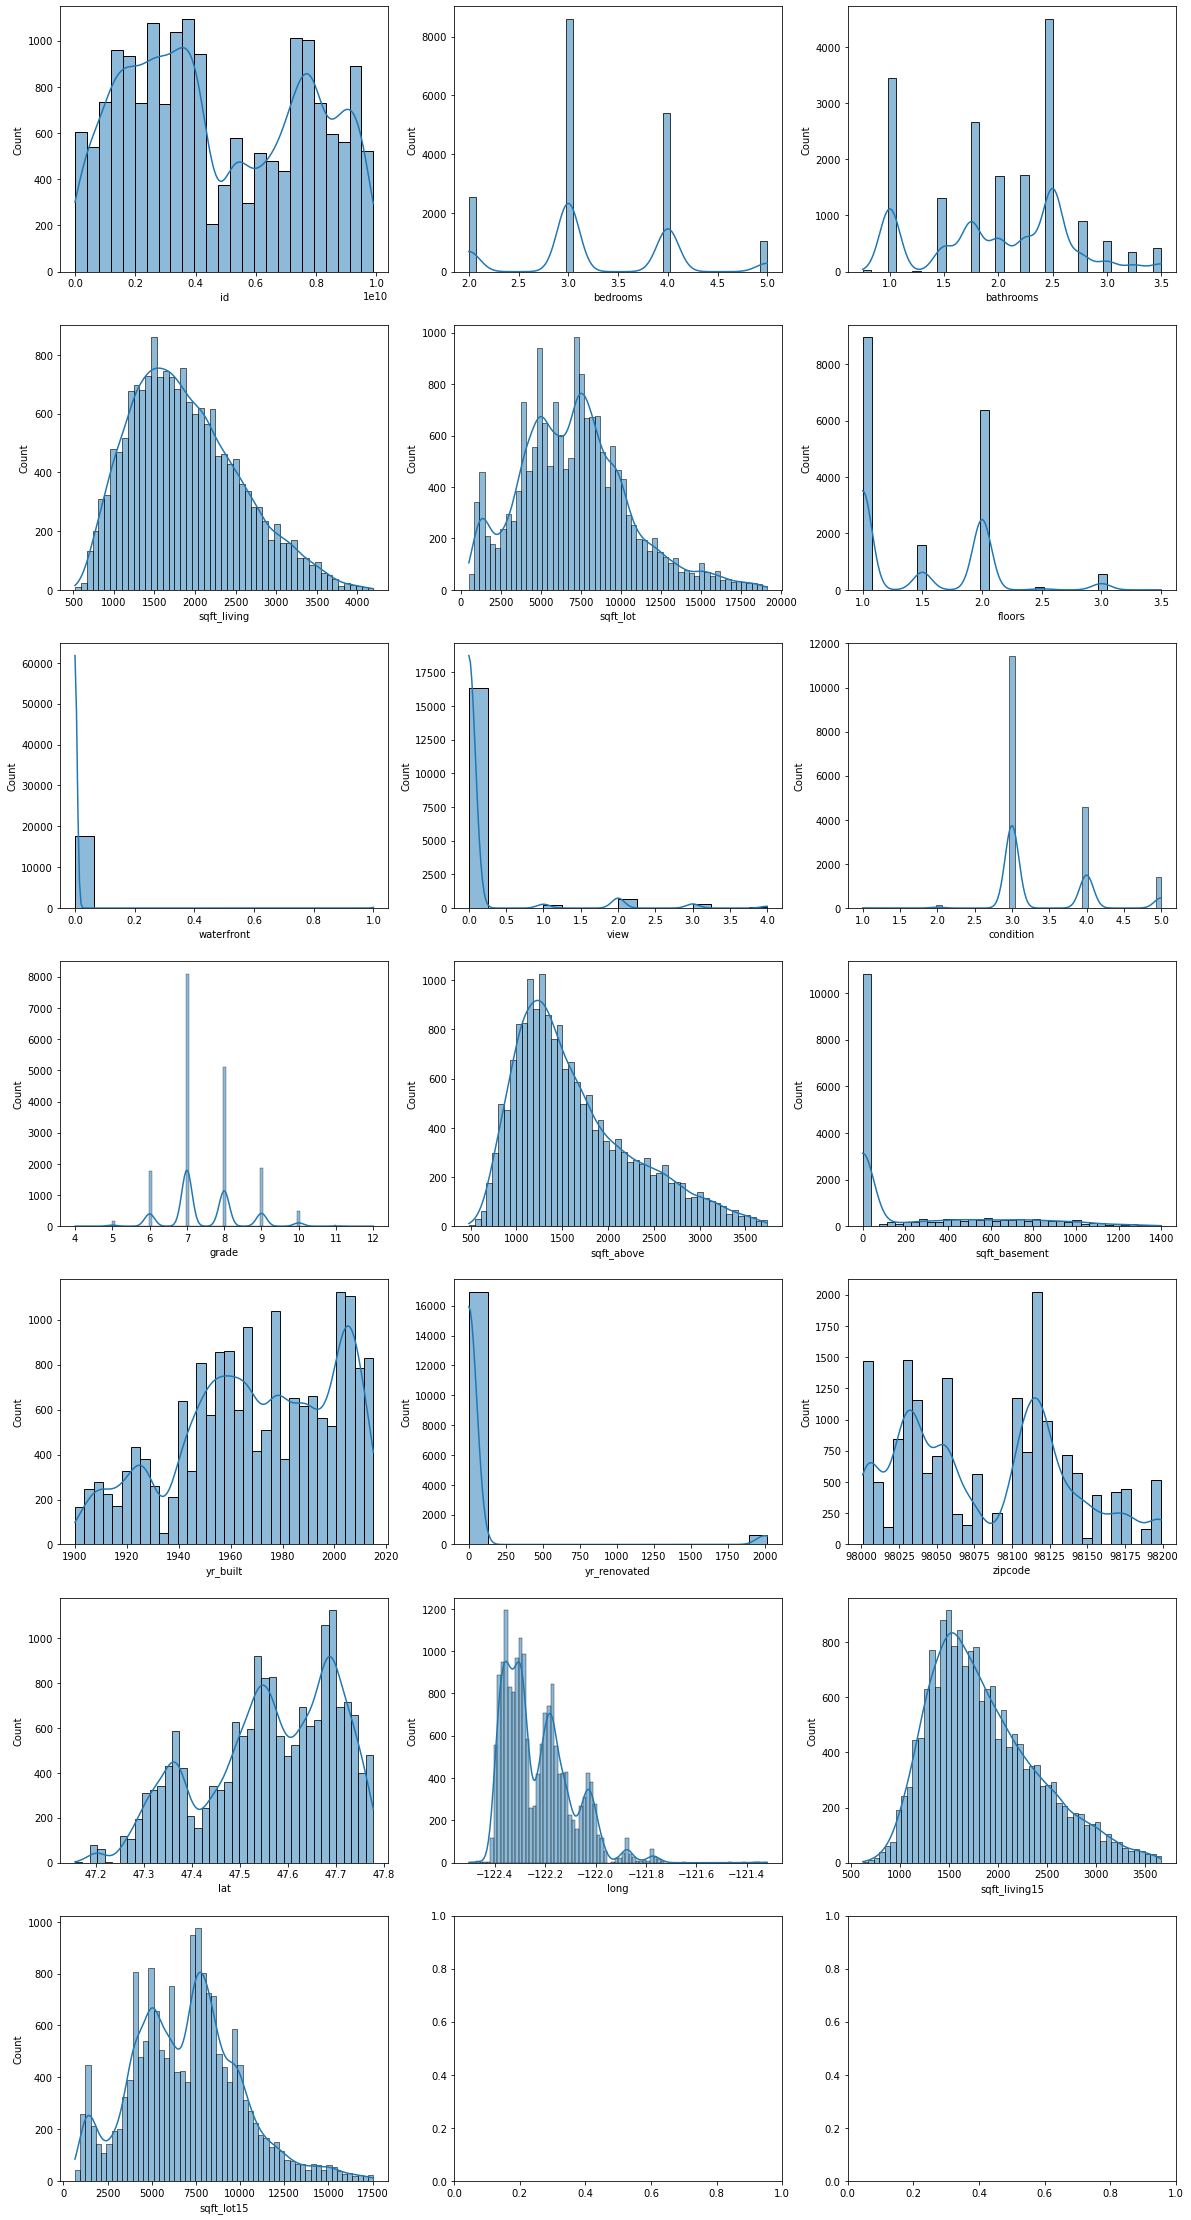

In [15]:
#Histogram plot for each features

#creating feature list 
feature_col = list(housing_no_outlier.drop(DropList,axis=1).columns)

# We have 19 features to plot at 7x3 subplots. 
ncols= 3
nrows= (len(feature_col) + ncols)//ncols


#creating total number of plot for histogram
fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,40))

for index, col_name in enumerate (feature_col):
    plt.subplot(nrows,ncols,index+1)
    sns.histplot(housing_no_outlier[col_name],kde=True)

In [16]:
X_add_const = sm.add_constant(housing_no_outlier.drop(DropList,axis=1))
lr = sm.OLS(housing_no_outlier['price'],X_add_const).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     2048.
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:19:19   Log-Likelihood:            -2.3299e+05
No. Observations:               17578   AIC:                         4.660e+05
Df Residuals:                   17559   BIC:                         4.662e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           2.58e+06   2.27e+06      1.138

After removing outlier $R^2$ value is get decreased. Let's build the model with both with and without outlier.

In [17]:
# Creating X,y variables (with outlier)
X = housing.drop(DropList,axis=1)
y = housing.price

for random_state in range(10,15):
    #creating training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=random_state)

    #Train the model and predicting the test dataset
    model = LinearRegression()      # Instatiate
    model.fit(X_train, y_train)     # Feeding data into model
    y_pred = model.predict(X_test)  # Predicting test set

    r2 = r2_score(y_test,y_pred)
    print(f'r2 at random_state {random_state} = ',np.round(r2,2))

r2 at random_state 10 =  0.7
r2 at random_state 11 =  0.71
r2 at random_state 12 =  0.69
r2 at random_state 13 =  0.72
r2 at random_state 14 =  0.7


In [18]:
# Creating X,y variables (without outlier)
X = housing_no_outlier.drop(DropList,axis=1)
y = housing_no_outlier.price

for random_state in range(10,15):
    #creating training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=random_state)

    #Train the model and predicting the test dataset
    model = LinearRegression()      # Instatiate
    model.fit(X_train, y_train)     # Feeding data into model
    y_pred = model.predict(X_test)  # Predicting test set

    r2 = r2_score(y_test,y_pred)
    print(f'r2 at random_state {random_state} = ',np.round(r2,2))

r2 at random_state 10 =  0.66
r2 at random_state 11 =  0.67
r2 at random_state 12 =  0.68
r2 at random_state 13 =  0.66
r2 at random_state 14 =  0.68


Removing outlier doesn't help to improve result.

#### Correlation of features

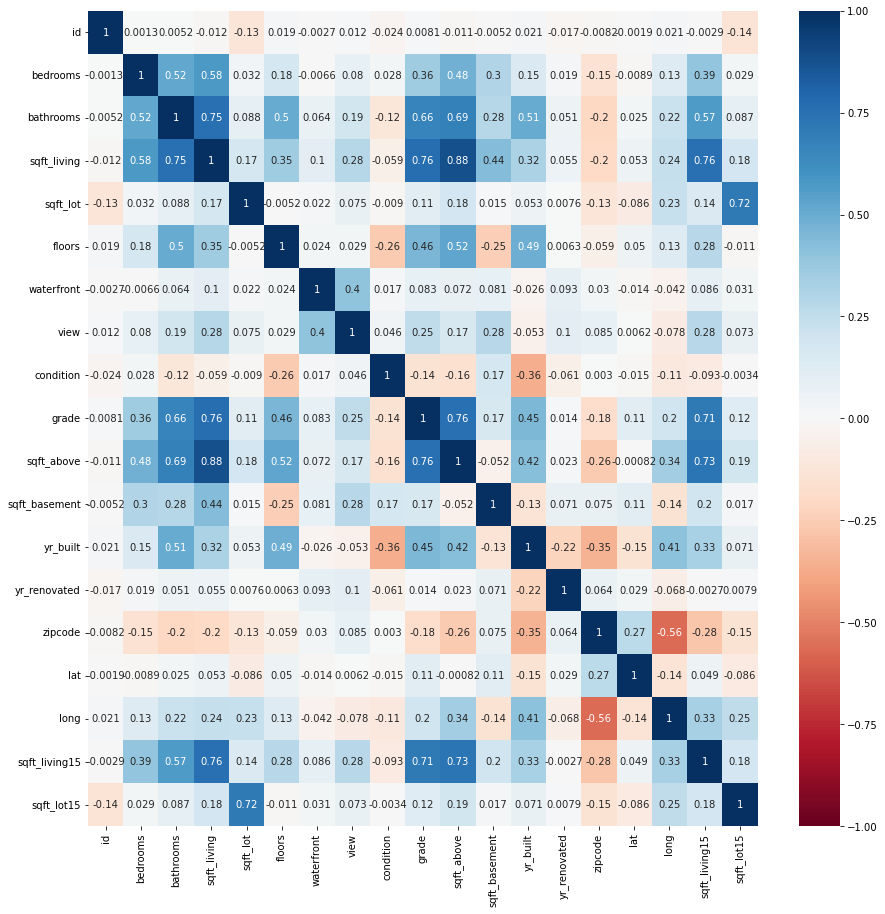

In [19]:
plt.figure(figsize=(15,15))
sns.heatmap(housing.drop(DropList,axis=1).corr(),cmap='RdBu',center=0,vmin=-1,vmax=1,annot=True)
plt.show()

Let's find out correlation of highly correlated features

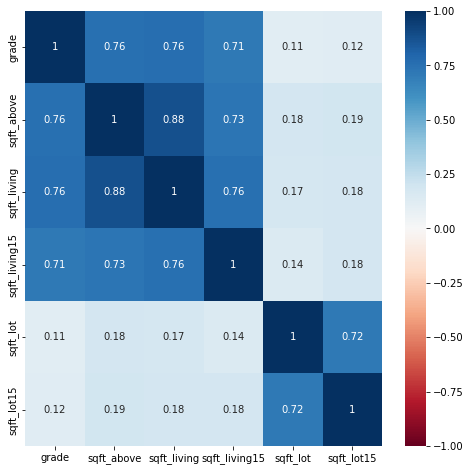

In [20]:
correlated_cloumn = ['grade','sqft_above','sqft_living','sqft_living15','sqft_lot','sqft_lot15']

plt.figure(figsize=(8,8))
sns.heatmap(housing[correlated_cloumn].corr(),cmap='RdBu',center=0,vmin=-1,vmax=1,annot=True)
plt.show()

In [21]:
X = housing.drop(DropList,axis=1)
y = housing.price

for random_state in range(10,15):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train[correlated_cloumn])
    X_test_sc = sc.transform(X_test[correlated_cloumn])

    # PCA
    n_components=3
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)
    
    # Creating training and testing pca set
    labels = ['PC'+ str(i) for i in range(1,n_components+1)]
    train_pca_df = pd.DataFrame(X_train_pca,columns=labels[0:11])
    test_pca_df = pd.DataFrame(X_test_pca,columns=labels[0:11])
      
    housing_train_pca = pd.concat([X_train.reset_index(drop=True), train_pca_df],axis=1).drop(correlated_cloumn,axis=1)
    housing_test_pca = pd.concat([X_test.reset_index(drop=True), test_pca_df],axis=1).drop(correlated_cloumn,axis=1)
    
    model = LinearRegression()      
    model.fit(housing_train_pca, y_train)     
    y_pred = model.predict(housing_test_pca)  

    r2 = r2_score(y_test,y_pred)
    print(f'r2 at random_state {random_state} = ',np.round(r2,2))

r2 at random_state 10 =  0.71
r2 at random_state 11 =  0.7
r2 at random_state 12 =  0.69
r2 at random_state 13 =  0.7
r2 at random_state 14 =  0.7


No major difference in accuracy is observed after PCA.

In [22]:
print(X_train.shape)
print(housing_train_pca.shape)

(15129, 19)
(15129, 16)


3 features have been reduced after PCA.

In [23]:
n_components=3
pca = PCA(n_components=n_components)
pca_values = pca.fit_transform(housing[correlated_cloumn])
labels = ['PC'+ str(i) for i in range(1,n_components+1)]
df_pca = pd.DataFrame(pca_values,columns=labels[0:11])
housing_pca = pd.concat([housing, df_pca],axis=1).drop(correlated_cloumn,axis=1)
housing_pca.shape # total 18 columns including DropList 

(21613, 18)

#### VIF Analysis

In [24]:
housing_feature = housing_pca.drop('price',axis=1)
VIF_data = pd.DataFrame()
VIF_data['feature'] = housing_feature.columns
VIF_data["VIF"] = [variance_inflation_factor(housing_feature.values, i) for i in range(len(housing_feature.columns))]
VIF_data.sort_values(by='VIF',ascending=False)

,feature,VIF
0,id,1.021917
14,PC1,1.020649
3,bathrooms,1.007696
6,view,1.006913
1,date,1.001454
15,PC2,1.001266
5,waterfront,1.000949
16,PC3,1.000440
10,yr_renovated,1.000239
8,sqft_basement,1.000125


VIF of all columns are <6. Therefore no option to reduce. Let's check correlation of of each column with price.

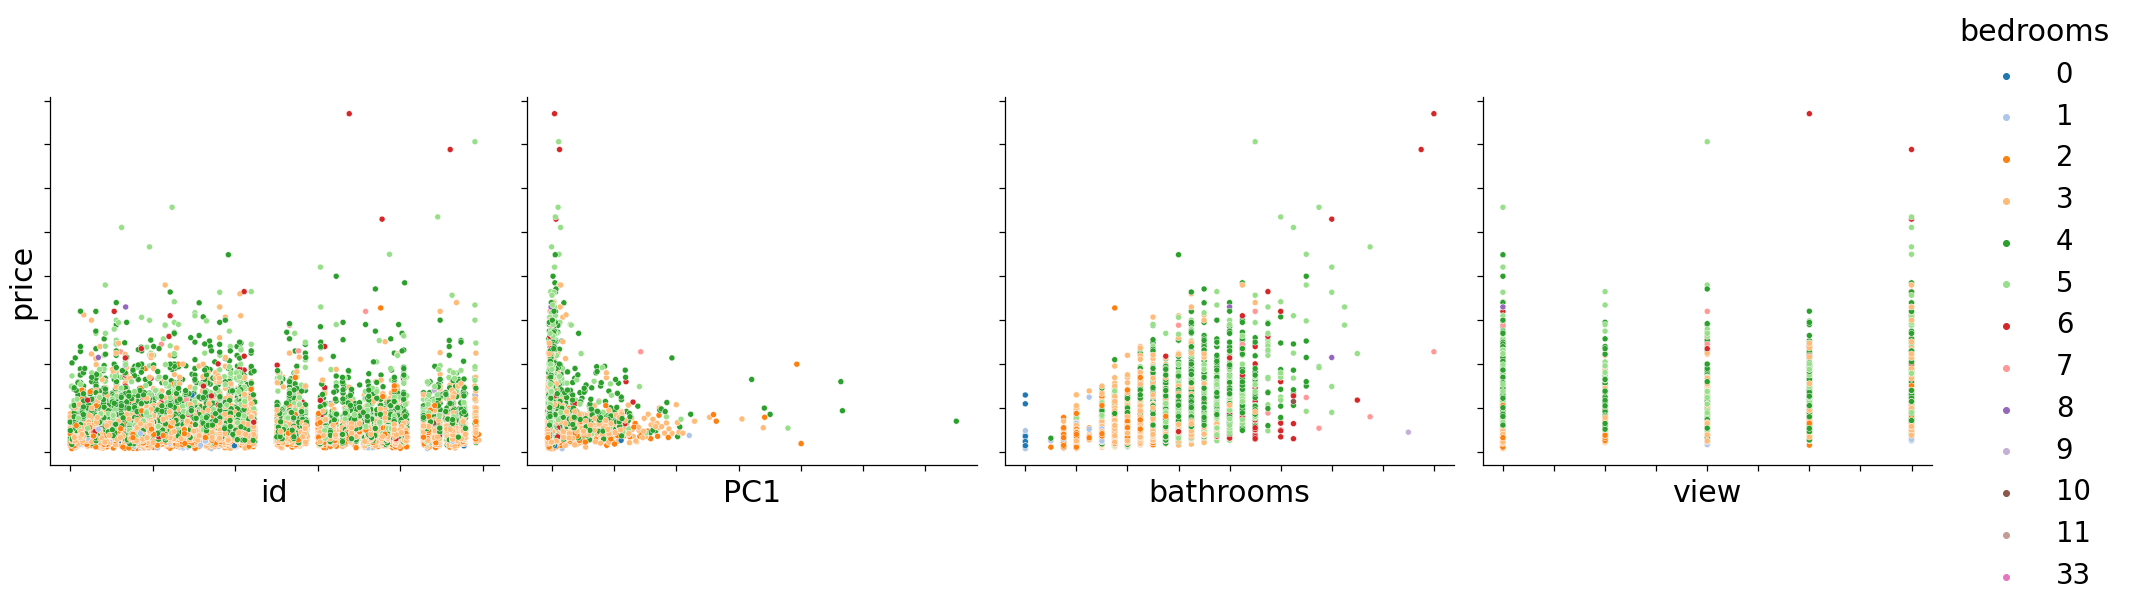

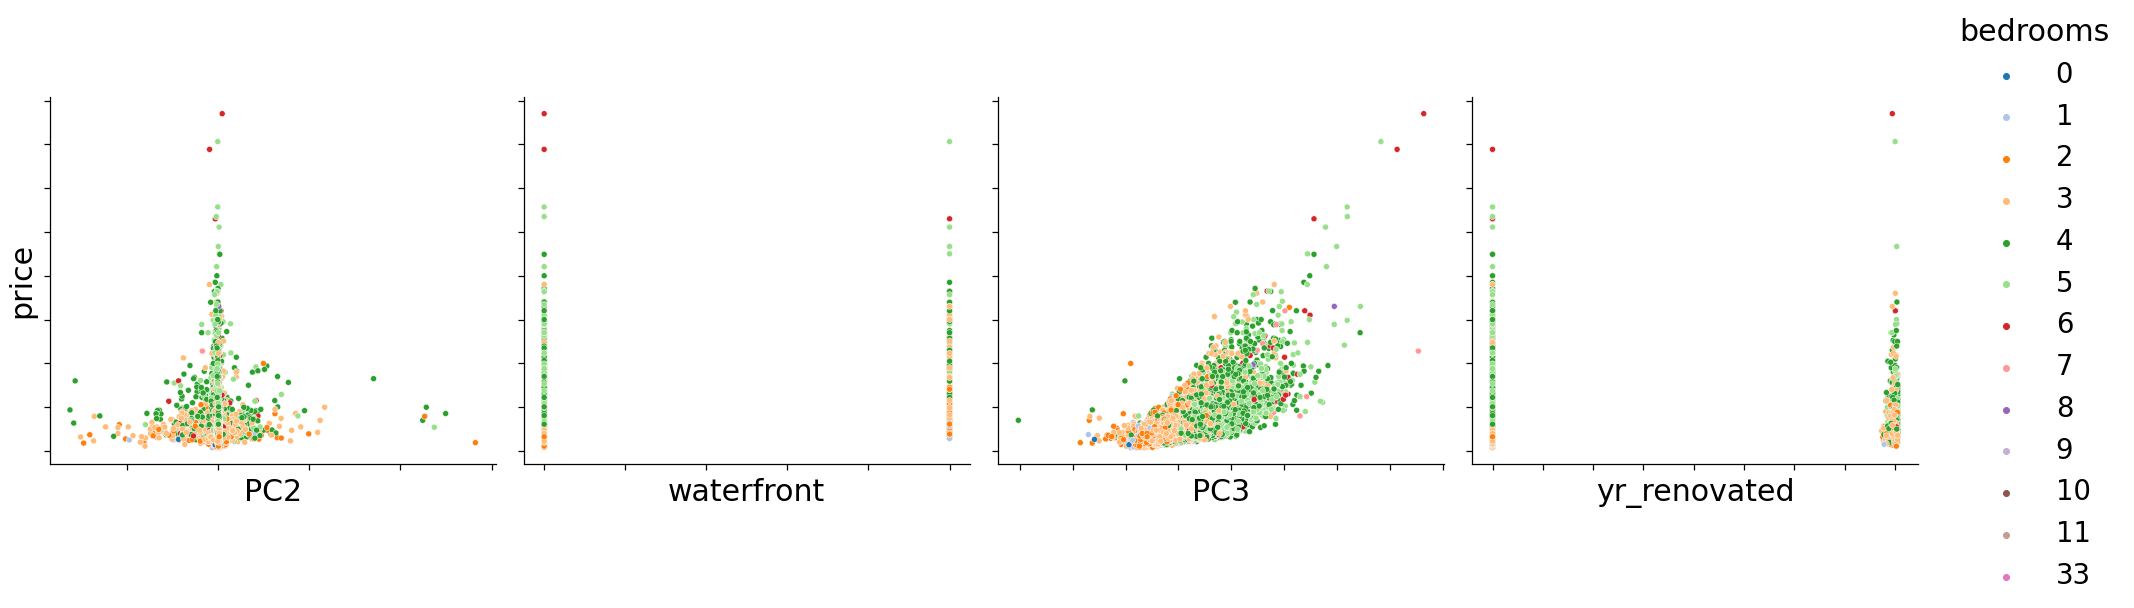

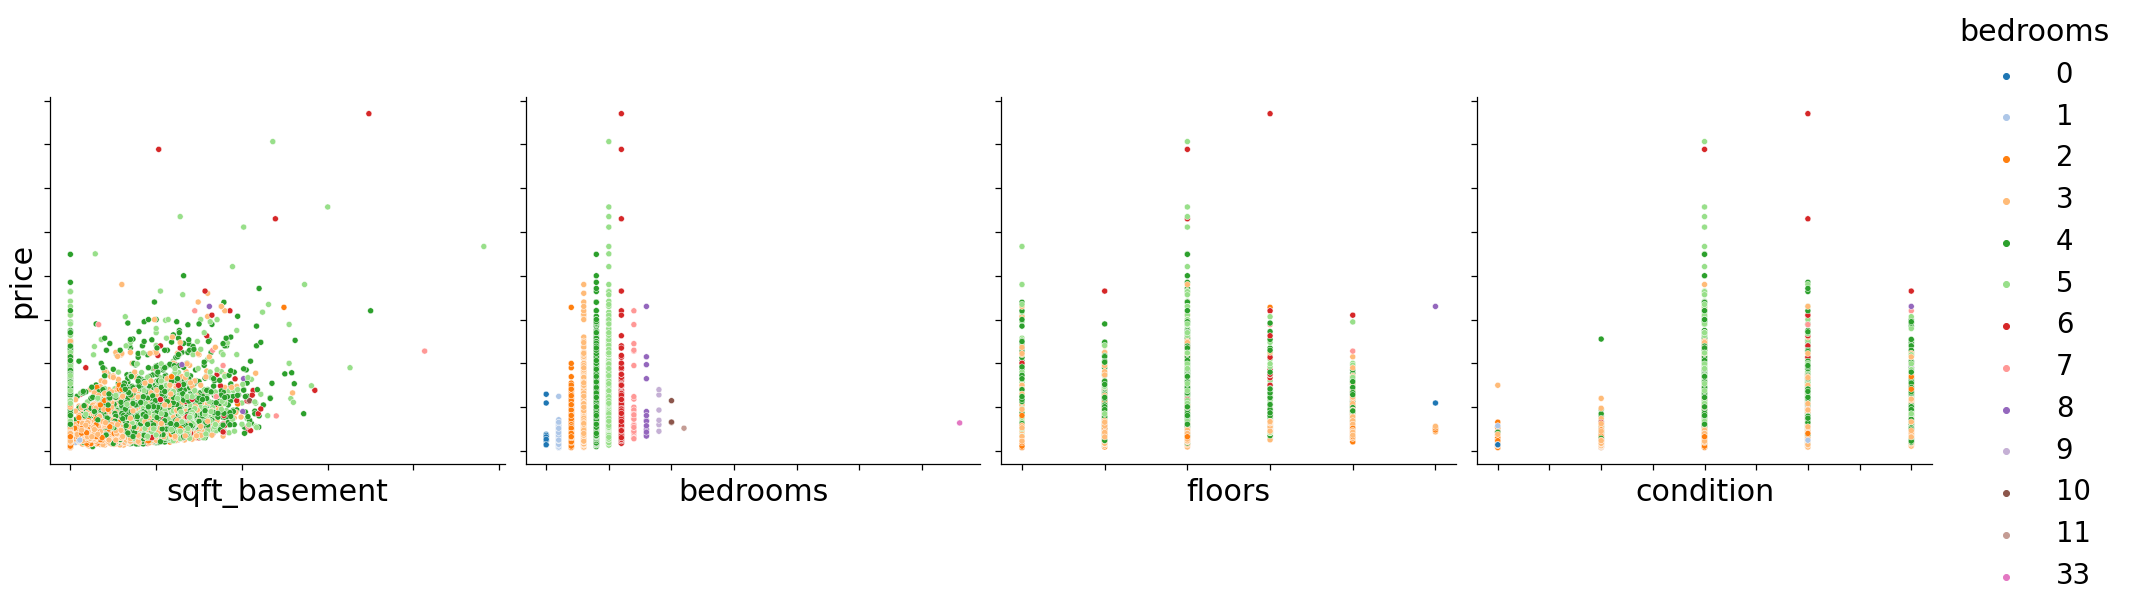

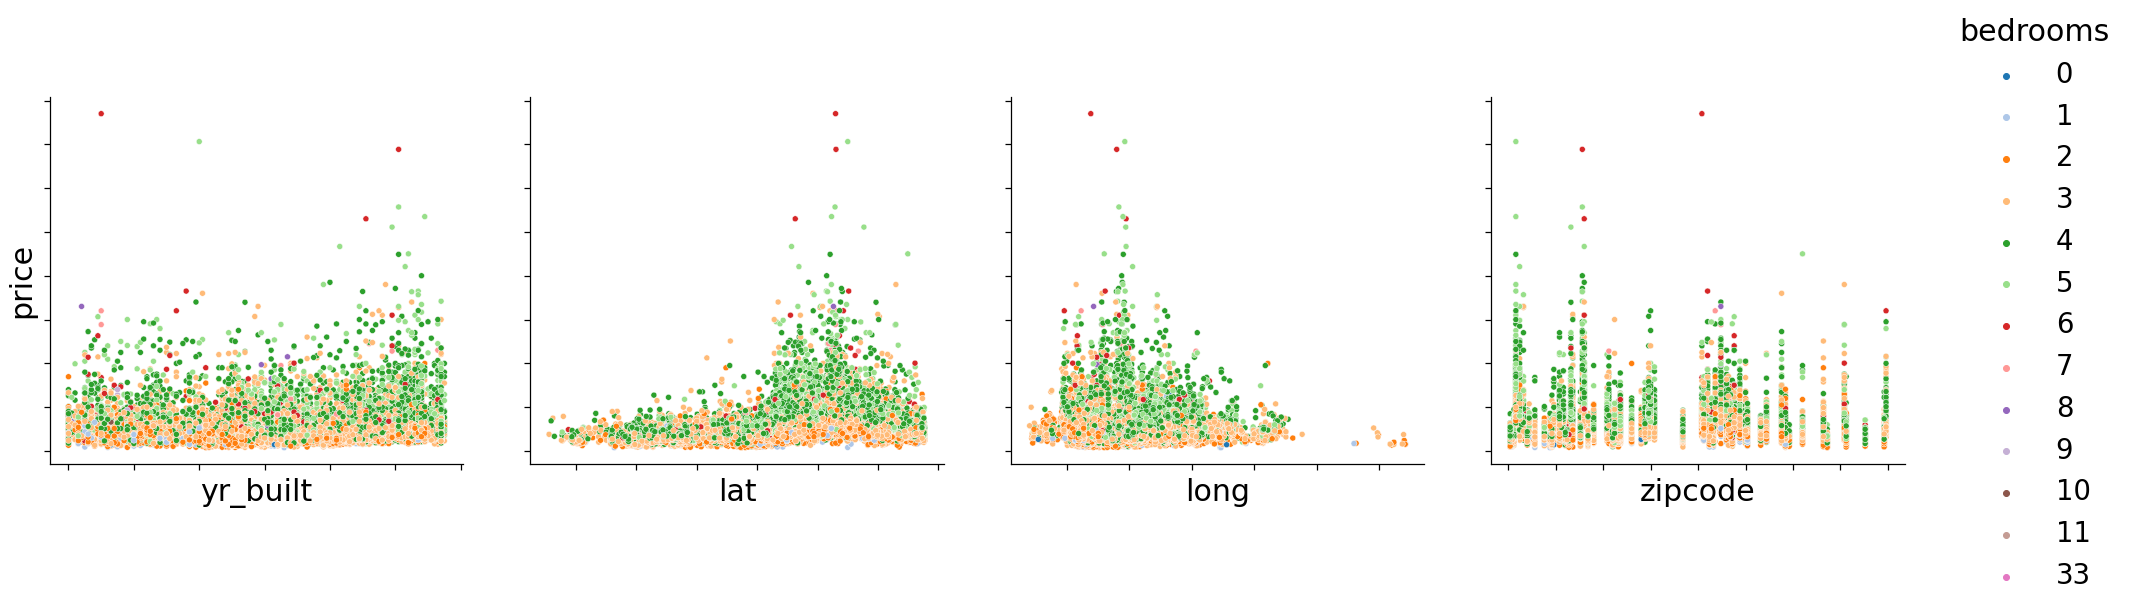

In [25]:
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(x_vars=['id','PC1','bathrooms','view'],y_vars=['price'],
                 data=housing_pca,height=7,hue='bedrooms',palette='tab20')
    h = sns.pairplot(x_vars=['PC2','waterfront','PC3','yr_renovated'],y_vars=['price'],
                 data=housing_pca,height=7,hue='bedrooms',palette='tab20')
    i = sns.pairplot(x_vars=['sqft_basement','bedrooms','floors', 'condition'],y_vars=['price'],
             data=housing_pca,height=7,hue='bedrooms',palette='tab20')   
    k = sns.pairplot(x_vars=['yr_built','lat','long','zipcode'],y_vars=['price'],
             data=housing_pca,height=7,hue='bedrooms',palette='tab20')
    
g.set(xticklabels=[],yticklabels=[])
h.set(xticklabels=[],yticklabels=[])
i.set(xticklabels=[],yticklabels=[])
k.set(xticklabels=[],yticklabels=[])
plt.show()

In [26]:
housing_pca.corr().price.abs().sort_values(ascending=False)

price            1.000000
PC3              0.683135
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
PC1              0.093145
yr_built         0.054012
zipcode          0.053203
condition        0.036362
long             0.021626
id               0.016762
PC2              0.007617
date             0.004357
Name: price, dtype: float64

In [27]:
# Removing 'zipcode','condition','id','PC2'
DropList2 = DropList + ['zipcode','condition','id','PC2']

features = list(housing_pca.columns)

for list_ in DropList2:
    features.remove(list_)

X = housing_pca[features].copy()
y = housing_pca.price

for random_state in range(10,15):
    #creating training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=random_state)

    #Train the model and predicting the test dataset
    model = LinearRegression()      # Instatiate
    model.fit(X_train, y_train)     # Feeding data into model
    y_pred = model.predict(X_test)  # Predicting test set

    r2 = r2_score(y_test,y_pred)
    print(f'r2 at random_state {random_state} = ',np.round(r2,2))

r2 at random_state 10 =  0.68
r2 at random_state 11 =  0.66
r2 at random_state 12 =  0.66
r2 at random_state 13 =  0.68
r2 at random_state 14 =  0.67


In [34]:
# Standardizing X
for random_state in range(10,15):
    #creating training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=random_state)

    #Train the model and predicting the test dataset
    
    model = make_pipeline(StandardScaler(with_mean=True), LinearRegression())      # Instatiate
    model.fit(X_train, y_train)     # Feeding data into model
    y_pred = model.predict(X_test)  # Predicting test set

    r2 = r2_score(y_test,y_pred)
    print(f'r2 at random_state {random_state} = ',np.round(r2,2))

r2 at random_state 10 =  0.68
r2 at random_state 11 =  0.66
r2 at random_state 12 =  0.66
r2 at random_state 13 =  0.68
r2 at random_state 14 =  0.67


In [28]:
for random_state in range(10,15):
    #creating training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=random_state)

    #Train the model and predicting the test dataset
    model = RandomForestRegressor()      # Instatiate
    model.fit(X_train, y_train)     # Feeding data into model
    y_pred = model.predict(X_test)  # Predicting test set

    r2 = r2_score(y_test,y_pred)
    print(f'r2 at random_state {random_state} = ',np.round(r2,2))

r2 at random_state 10 =  0.88
r2 at random_state 11 =  0.87
r2 at random_state 12 =  0.88
r2 at random_state 13 =  0.89
r2 at random_state 14 =  0.88


**Conclusion:** Random forest gives the best result with 88% accuracy.